# Network propagation analysis for lithium response genes


8/23/18: add clustering and annotation

7/8/19: update with less stringent GWAB/NETWAS criteria (use top 5%)

9/27/19: find GWAB in top 2000 network

9/30/20: print out top 2000 genes at vipavee's request

In [2]:
# need to update things to work on new laptop

import sys
code_path = 'netprop_zscore_code/'
sys.path.append(code_path)


In [3]:
import network_prop

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import community


# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

sns.set_style('white')

import sys

% matplotlib inline

# Load the GIANT brain interactome

In [5]:
Gint = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/GIANT/G_giant_.2.gpickle')

In [6]:
print(len(Gint.nodes()))
print(len(Gint.edges()))

14563
1370265


# Load the RNAseq DE genes

In [7]:
rna_df = pd.read_excel('data/DE_Genes_Li and CTRL_LRvsNR_for_Katie.xlsx',index_col='SYMBOL')
rna_df.head()

,#,ENSEMBL,ENTREZID,logFC,AveExpr,t,P.Value,adj.P.Val,B,Unnamed: 10,sig in
SYMBOL,,,,,,,,,,,
ADAMTS14,33.0,ENSG00000138316,140766.0,-3.220477,0.387776,-3.765437,0.000471,0.180478,-0.476563,CTRL.LRvsNR,CTRL.LRvsNR
ADAMTS14,NaN,ENSG00000138316,140766.0,-3.055752,0.387776,-3.408920,0.001367,0.267570,-1.335573,Li.LRvsNR,NaN
ADAMTS4,17.0,ENSG00000158859,9507.0,-1.425119,2.764865,-4.120282,0.000156,0.118895,0.789911,CTRL.LRvsNR,CTRL.LRvsNR
ADAMTS4,NaN,ENSG00000158859,9507.0,-1.309927,2.764865,-3.675049,0.000620,0.222346,-0.394257,Li.LRvsNR,NaN
APCDD1,21.0,ENSG00000154856,147495.0,1.515762,6.699247,3.948413,0.000268,0.151966,0.372925,Li.LRvsNR,Li.LRvsNR


In [8]:
DE_genes = rna_df[rna_df['adj.P.Val']<0.3].index.unique().dropna().tolist()
print(len(DE_genes))
DE_genes

41


[u'ADAMTS14',
 u'ADAMTS4',
 u'APCDD1',
 u'BGN',
 u'BTBD17',
 u'CHRD',
 u'CHST6',
 u'COL15A1',
 u'COL16A1',
 u'COL6A3',
 u'CPNE5',
 u'DLC1',
 u'DSP',
 u'EFNA1',
 u'FLNC',
 u'FOXO6',
 u'HEY1',
 u'HOXD9',
 u'IAH1',
 u'IGFBP3',
 u'IL17RC',
 u'KLF10',
 u'LEF1',
 u'LMX1B',
 u'MBP',
 u'MMP14',
 u'MXRA5',
 u'OLFML2B',
 u'PDGFA',
 u'POU3F1',
 u'PRKD1',
 u'PTP4A3',
 u'RWDD2B',
 u'SEMA3A',
 u'SLC2A1',
 u'TBX1',
 u'THNSL2',
 u'TPD52',
 u'TPM2',
 u'ZIC1',
 u'ZNF132']

In [9]:
print(len(np.intersect1d(DE_genes,Gint.nodes())))

34


# Load the re-prioritized GWAS hits

In [11]:
# changed 7/8/19 to top 5% results
vegas_genes = pd.read_excel('data/prioritized_genes_boosting_methods_5percent_190708.xlsx',sheetname='vegas_genes',
                           index_col='Gene').index.tolist()
print(len(vegas_genes))

netwas_genes = pd.read_excel('data/prioritized_genes_boosting_methods_5percent_190708.xlsx',sheetname='netwas_genes',
                           index_col='Gene').index.tolist()
print(len(netwas_genes))

gwab_genes = pd.read_excel('data/prioritized_genes_boosting_methods_5percent_190708.xlsx',sheetname='gwab_genes',
                           index_col='Gene').index.tolist()
print(len(gwab_genes))

1180
964
1119


In [12]:
np.intersect1d(DE_genes,gwab_genes)

array([u'FLNC', u'LEF1', u'MBP', u'PRKD1'], dtype='<U12')

In [13]:
gwab_df = pd.read_excel('data/prioritized_genes_boosting_methods_5percent_190708.xlsx',sheetname='gwab_genes',
                           index_col='Gene')
gwab_df.head()

,Chr,nSNPs,Pvalue,TopSNP,TopSNP-pvalue,GWAB_Score
Gene,,,,,,
UBC,12.0,45.0,0.198801,rs142622917,0.012040,26.441133
APP,21.0,798.0,0.081918,rs363999,0.007441,18.161573
SUMO1,2.0,108.0,0.505495,rs72923074,0.018980,15.222024
HSP90AA1,14.0,185.0,0.187812,rs145643636,0.001290,15.164895
GRB2,17.0,263.0,0.591409,rs144626626,0.028820,14.811854


# Network propagation from DE genes

In [14]:
alt_DE_genes = ['HEY1','KLF10','PDGFA','POU3F1','PTP4A3'] # these are significant in another study (Breen et al)


In [15]:
Wprime = network_prop.normalized_adj_matrix(Gint)

In [16]:
seed_type='41_DE_genes'
if seed_type=='HC_DE_genes':
    seed_nodes = list(np.intersect1d(alt_DE_genes,Gint.nodes()))
elif seed_type=='41_DE_genes':
    seed_nodes = list(np.intersect1d(DE_genes,Gint.nodes()))

# Fnew = visJS2jupyter.visualizations.network_propagation(Gint,Wprime,seed_nodes)
Fnew = network_prop.network_propagation(Gint,Wprime,seed_nodes)

In [17]:
Fnew = Fnew.sort_values(ascending=False)
Fnew.head()

IL17RC    0.015857
BGN       0.015617
POU3F1    0.015064
MMP14     0.015053
SLC2A1    0.015023
dtype: float64

In [18]:
# write out top 2000 genes for vipavee 9/30/20
# pd.DataFrame(Fnew.head(2000),columns=['netprop_score_top2000']).to_csv('2KGWAB/top2000_network_prop_genes.txt',sep='\t')


In [18]:
print(len(nx.subgraph(Gint,Fnew.head(500).index.tolist()).edges()))

25020


In [19]:
Fnew.loc[alt_DE_genes]

HEY1      0.015005
KLF10     0.014745
PDGFA     0.014924
POU3F1    0.015064
PTP4A3    0.015007
dtype: float64

In [20]:
print(len(np.intersect1d(Fnew.head(500).index,vegas_genes)))
print(len(np.intersect1d(Fnew.head(500).index,netwas_genes)))
print(len(np.intersect1d(Fnew.head(500).index,gwab_genes)))

36
33
73


In [21]:
# remove seed genes
print(len(Fnew))
Fnew_no_seeds = Fnew.drop(seed_nodes)
print(len(Fnew_no_seeds))

14563
14529


In [22]:
import scipy
# hypergeom results for top 500 genes

# remove seed genes
print(len(Fnew))
Fnew_no_seeds = Fnew.drop(seed_nodes)
print(len(Fnew_no_seeds))

N = 2000

M = len(Fnew_no_seeds)
n_netwas = len(np.intersect1d(netwas_genes,Fnew_no_seeds.index)) # make sure the genes are in the interactome
#N = 3000 # test how many are found in the top N 
x_netwas = len(np.intersect1d(netwas_genes,Fnew_no_seeds.head(N).index))

print('netwas p = ' + str(scipy.stats.hypergeom.sf(x_netwas,M,n_netwas,N)))


n_gwab = len(np.intersect1d(gwab_genes,Fnew_no_seeds.index)) # make sure the genes are in the interactome
x_gwab = len(np.intersect1d(gwab_genes,Fnew_no_seeds.head(N).index))

print('gwab p = ' + str(scipy.stats.hypergeom.sf(x_gwab,M,n_gwab,N)))

n_vegas = len(np.intersect1d(vegas_genes,Fnew_no_seeds.index)) # make sure the genes are in the interactome
x_vegas = len(np.intersect1d(vegas_genes,Fnew_no_seeds.head(N).index))

print('vegas p = ' + str(scipy.stats.hypergeom.sf(x_vegas,M,n_vegas,N)))


14563
14529
netwas p = 0.10169896981203852
gwab p = 1.3515472120439197e-17
vegas p = 0.007504025225436693


In [23]:
# hypergeometric test between two sets
import scipy.stats
netwas_hypergeo = []
gwab_hypergeo = []
vegas_hypergeo = []
Nlist = np.linspace(100,5000,25)
for N in Nlist: #[500,2000]: #Nlist:
    N = int(N) # cast to int

    M = len(Fnew)
    n_netwas = len(np.intersect1d(netwas_genes,Fnew.index)) # make sure the genes are in the interactome
    #N = 3000 # test how many are found in the top N 
    x_netwas = len(np.intersect1d(netwas_genes,Fnew.head(N).index))

#     print('netwas p = ' + str(scipy.stats.hypergeom.sf(x_netwas,M,n_netwas,N)))

    netwas_hypergeo.append(-scipy.stats.hypergeom.logsf(x_netwas,M,n_netwas,N))
    
    n_gwab = len(np.intersect1d(gwab_genes,Fnew.index)) # make sure the genes are in the interactome
    x_gwab = len(np.intersect1d(gwab_genes,Fnew.head(N).index))
    
#     print('gwab p = ' + str(scipy.stats.hypergeom.sf(x_gwab,M,n_gwab,N)))
    gwab_hypergeo.append(-scipy.stats.hypergeom.logsf(x_gwab,M,n_gwab,N))
    
    n_vegas = len(np.intersect1d(vegas_genes,Fnew.index)) # make sure the genes are in the interactome
    x_vegas = len(np.intersect1d(vegas_genes,Fnew.head(N).index))
    
#     print('vegas p = ' + str(scipy.stats.hypergeom.sf(x_vegas,M,n_vegas,N)))
    vegas_hypergeo.append(-scipy.stats.hypergeom.logsf(x_vegas,M,n_vegas,N))
    
    



Text(0,0.5,'hypergeometric\n-log(p)')

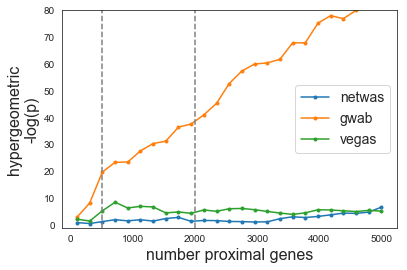

In [24]:
plt.plot(Nlist,netwas_hypergeo,'.-',label='netwas')
plt.plot(Nlist,gwab_hypergeo,'.-',label='gwab')
plt.plot(Nlist,vegas_hypergeo,'.-',label='vegas')
plt.legend(loc='best',fontsize=14)
plt.xlabel('number proximal genes',fontsize=16)
plt.plot([500,500],[-1,80],'--',color='gray')
plt.plot([2000,2000],[-1,80],'--',color='gray')
plt.ylim([-1,80])
plt.ylabel('hypergeometric\n-log(p)',fontsize=16)
# plt.savefig('../figures/hypergeo_netprop_scan_numProx_top5percent_190828.png',dpi=300,bbox_inches='tight')

# Save out the GWAB + seed genes in top 2000 network

In [25]:
gwab_2K = list(np.intersect1d(gwab_genes,Fnew.head(2000).index))
print(len(gwab_2K))

241


In [26]:
G_gwab2k_seeds = nx.subgraph(Gint,gwab_2K+seed_nodes)
print(len(G_gwab2k_seeds.nodes()))
print(len(G_gwab2k_seeds.edges()))



271
3135


In [27]:
nodes_table_2k = pd.DataFrame(index=G_gwab2k_seeds.nodes())
nodes_table_2k['net_prop']=Fnew.loc[G_gwab2k_seeds.nodes()]
nodes_table_2k['log_net_prop']=np.log(Fnew.loc[G_gwab2k_seeds.nodes()])

nodes_table_2k['seed_gene']=np.zeros(len(nodes_table_2k))
nodes_table_2k['seed_gene'].loc[np.intersect1d(seed_nodes,G_gwab2k_seeds.nodes())]=1.0 # make sure the DE genes are in the graph

nodes_table_2k['DE_RNAseq']=np.zeros(len(nodes_table_2k))
nodes_table_2k['DE_RNAseq'].loc[np.intersect1d(DE_genes,G_gwab2k_seeds.nodes())]=1.0 # make sure the DE genes are in the graph

nodes_table_2k['vegas_genes']=np.zeros(len(nodes_table_2k))
nodes_table_2k['vegas_genes'].loc[np.intersect1d(vegas_genes,G_gwab2k_seeds.nodes())]=1.0

nodes_table_2k['netwas_genes']=np.zeros(len(nodes_table_2k))
nodes_table_2k['netwas_genes'].loc[np.intersect1d(netwas_genes,G_gwab2k_seeds.nodes())]=1.0

nodes_table_2k['gwab_genes']=np.zeros(len(nodes_table_2k))
nodes_table_2k['gwab_genes'].loc[np.intersect1d(gwab_genes,G_gwab2k_seeds.nodes())]=1.0

nodes_table_2k = nodes_table_2k.sort_values('net_prop',ascending=False)

# nodes_table_2k.to_csv('2KGWAB/G_netprop_2KGWAB_nodes_'+seed_type+'_5percent_190927.tsv',sep='\t')
print(len(nodes_table_2k))
print(nodes_table_2k['gwab_genes'].sum())
nodes_table_2k.head(15)

271
241.0


,net_prop,log_net_prop,seed_gene,DE_RNAseq,vegas_genes,netwas_genes,gwab_genes
IL17RC,0.015857,-4.144125,1.0,1.0,0.0,0.0,0.0
BGN,0.015617,-4.159392,1.0,1.0,0.0,0.0,0.0
POU3F1,0.015064,-4.195454,1.0,1.0,0.0,0.0,0.0
MMP14,0.015053,-4.196172,1.0,1.0,0.0,0.0,0.0
SLC2A1,0.015023,-4.198195,1.0,1.0,0.0,0.0,0.0
PTP4A3,0.015007,-4.199257,1.0,1.0,1.0,0.0,0.0
HEY1,0.015005,-4.199382,1.0,1.0,0.0,0.0,0.0
TBX1,0.014988,-4.200490,1.0,1.0,0.0,0.0,0.0
MXRA5,0.014978,-4.201194,1.0,1.0,0.0,0.0,0.0
DLC1,0.014973,-4.201515,1.0,1.0,0.0,0.0,0.0


In [28]:
# make the edge_info table

[e1,e2] = zip(*G_gwab2k_seeds.edges())
w = pd.Series(nx.get_edge_attributes(G_gwab2k_seeds,'weight')).loc[G_gwab2k_seeds.edges()].tolist()
edge_info = pd.DataFrame({'edge1':e1,'edge2':e2,'weight':w})
edge_info.head()
# edge_info.to_csv('2KGWAB/G_netprop_2KGWAB_edges_'+seed_type+'.tsv',sep='\t') # save the edges

,edge1,edge2,weight
0,MUSK,CYP2C9,0.222916
1,MUSK,ACTN2,0.216907
2,MUSK,ALDOB,0.304409
3,MUSK,GNAO1,0.267426
4,MUSK,XDH,0.202014


In [29]:
# genes with degree 0
pd.Series(nx.degree(G_gwab2k_seeds)).sort_values().head()

ZNF132    0
CHST6     0
ZIC1      1
LCK       2
VCAM1     3
dtype: int64

In [ ]:
# save out the top 2000 nodes with annotations, at vipavee's request (11/16/20)

In [30]:
Fnew = Fnew.sort_values(ascending=False)

nodes_table_2k_full = pd.DataFrame(index=Fnew.head(2000).index.tolist())
nodes_table_2k_full['net_prop']=Fnew.head(2000)
nodes_table_2k_full['log_net_prop']=np.log(Fnew.head(2000))

nodes_table_2k_full['seed_gene']=np.zeros(len(nodes_table_2k_full))
nodes_table_2k_full['seed_gene'].loc[np.intersect1d(seed_nodes,Fnew.head(2000).index.tolist())]=1.0 # make sure the DE genes are in the graph

nodes_table_2k_full['DE_RNAseq']=np.zeros(len(nodes_table_2k_full))
nodes_table_2k_full['DE_RNAseq'].loc[np.intersect1d(DE_genes,Fnew.head(2000).index.tolist())]=1.0 # make sure the DE genes are in the graph

nodes_table_2k_full['vegas_genes']=np.zeros(len(nodes_table_2k_full))
nodes_table_2k_full['vegas_genes'].loc[np.intersect1d(vegas_genes,Fnew.head(2000).index.tolist())]=1.0

nodes_table_2k_full['netwas_genes']=np.zeros(len(nodes_table_2k_full))
nodes_table_2k_full['netwas_genes'].loc[np.intersect1d(netwas_genes,Fnew.head(2000).index.tolist())]=1.0

nodes_table_2k_full['gwab_genes']=np.zeros(len(nodes_table_2k_full))
nodes_table_2k_full['gwab_genes'].loc[np.intersect1d(gwab_genes,Fnew.head(2000).index.tolist())]=1.0

nodes_table_2k_full = nodes_table_2k_full.sort_values('net_prop',ascending=False)

# nodes_table_2k_full.to_csv('2KGWAB/G_netprop_2K_nodes_'+seed_type+'_5percent_201118.tsv',sep='\t')
print(len(nodes_table_2k_full))
print(nodes_table_2k_full['gwab_genes'].sum())
nodes_table_2k_full.head(15)

2000
241.0


,net_prop,log_net_prop,seed_gene,DE_RNAseq,vegas_genes,netwas_genes,gwab_genes
IL17RC,0.015857,-4.144125,1.0,1.0,0.0,0.0,0.0
BGN,0.015617,-4.159392,1.0,1.0,0.0,0.0,0.0
POU3F1,0.015064,-4.195454,1.0,1.0,0.0,0.0,0.0
MMP14,0.015053,-4.196172,1.0,1.0,0.0,0.0,0.0
SLC2A1,0.015023,-4.198195,1.0,1.0,0.0,0.0,0.0
PTP4A3,0.015007,-4.199257,1.0,1.0,1.0,0.0,0.0
HEY1,0.015005,-4.199382,1.0,1.0,0.0,0.0,0.0
TBX1,0.014988,-4.200490,1.0,1.0,0.0,0.0,0.0
MXRA5,0.014978,-4.201194,1.0,1.0,0.0,0.0,0.0
DLC1,0.014973,-4.201515,1.0,1.0,0.0,0.0,0.0


In [33]:
# nodes_table_2k_full['gwab_genes'].sum()

241.0

# Save out the top 500 genes for visualization in cytoscape

In [31]:
topN=500

G_netprop = nx.subgraph(Gint,Fnew.head(topN).index.tolist())
print(len(G_netprop.nodes()))
print(len(G_netprop.edges()))

500
25020


In [32]:
# note there is some stochasticity in the clustering algorithm... results may differ slightly from run to run
partition = community.best_partition(G_netprop)
pd.Series(partition).value_counts()

0    236
1    168
2     96
dtype: int64

In [31]:
# save the partition
#pd.Series(partition).to_csv('partition_41_DE_genes_netprop_500.tsv',sep='\t')

In [33]:
nodes_table = pd.DataFrame(index=G_netprop.nodes())
nodes_table['net_prop']=Fnew.head(topN)
nodes_table['log_net_prop']=np.log(Fnew.head(topN))

nodes_table['seed_gene']=np.zeros(len(nodes_table))
nodes_table['seed_gene'].loc[np.intersect1d(seed_nodes,G_netprop.nodes())]=1.0 # make sure the DE genes are in the graph

nodes_table['DE_RNAseq']=np.zeros(len(nodes_table))
nodes_table['DE_RNAseq'].loc[np.intersect1d(DE_genes,G_netprop.nodes())]=1.0 # make sure the DE genes are in the graph

nodes_table['vegas_genes']=np.zeros(len(nodes_table))
nodes_table['vegas_genes'].loc[np.intersect1d(vegas_genes,G_netprop.nodes())]=1.0

nodes_table['netwas_genes']=np.zeros(len(nodes_table))
nodes_table['netwas_genes'].loc[np.intersect1d(netwas_genes,G_netprop.nodes())]=1.0

nodes_table['gwab_genes']=np.zeros(len(nodes_table))
nodes_table['gwab_genes'].loc[np.intersect1d(gwab_genes,G_netprop.nodes())]=1.0

nodes_table = nodes_table.sort_values('net_prop',ascending=False)

# nodes_table.to_csv('G_netprop_nodes_'+seed_type+'_'+str(topN)+'_5percent_190708.tsv',sep='\t')

nodes_table.head(15)

,net_prop,log_net_prop,seed_gene,DE_RNAseq,vegas_genes,netwas_genes,gwab_genes
IL17RC,0.015857,-4.144125,1.0,1.0,0.0,0.0,0.0
BGN,0.015617,-4.159392,1.0,1.0,0.0,0.0,0.0
POU3F1,0.015064,-4.195454,1.0,1.0,0.0,0.0,0.0
MMP14,0.015053,-4.196172,1.0,1.0,0.0,0.0,0.0
SLC2A1,0.015023,-4.198195,1.0,1.0,0.0,0.0,0.0
PTP4A3,0.015007,-4.199257,1.0,1.0,1.0,0.0,0.0
HEY1,0.015005,-4.199382,1.0,1.0,0.0,0.0,0.0
TBX1,0.014988,-4.200490,1.0,1.0,0.0,0.0,0.0
MXRA5,0.014978,-4.201194,1.0,1.0,0.0,0.0,0.0
DLC1,0.014973,-4.201515,1.0,1.0,0.0,0.0,0.0


In [34]:
sum(nodes_table['vegas_genes'])

36.0

In [35]:
# make the edge_info table

[e1,e2] = zip(*G_netprop.edges())
w = pd.Series(nx.get_edge_attributes(G_netprop,'weight')).loc[G_netprop.edges()].tolist()
edge_info = pd.DataFrame({'edge1':e1,'edge2':e2,'weight':w})
# edge_info.to_csv('G_netprop_edges_'+seed_type+'_'+str(topN)+'.tsv',sep='\t') # save the edges

In [36]:
# print out the recovered genes
nodes_table[(nodes_table['vegas_genes']==1)|(nodes_table['netwas_genes']==1)|(nodes_table['gwab_genes']==1)].sum()

net_prop          0.141461
log_net_prop   -982.188402
seed_gene         6.000000
DE_RNAseq         6.000000
vegas_genes      36.000000
netwas_genes     33.000000
gwab_genes       73.000000
dtype: float64

# Gprofiler annotation of clusters

In [38]:
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

In [39]:
partition = pd.Series(partition)
partition.value_counts()

0    236
1    168
2     96
dtype: int64

In [40]:
import os

savedir_gprofile = 'gprofile_clusters_top'+str(topN)
if not os.path.isdir(savedir_gprofile):
    os.mkdir(savedir_gprofile)


for focal_cluster in partition.value_counts().index.tolist():
    print(focal_cluster)
    focal_genes = partition[partition==focal_cluster].index.tolist()

    gp_results = pd.DataFrame(gp.gprofile(focal_genes,custom_bg = partition.index.tolist(),correction_method=gp.THR_FDR))
    
    if len(gp_results)>0:
        gp_results.columns = ["query.number", "significant", "p.value", "term.size",
                              "query.size", "overlap.size", "recall", "precision",
                              "term.id", "domain", "subgraph.number", "term.name",
                              "relative.depth", "intersection"]
        print(gp_results[['p.value','term.id','term.name']].head())

#         writer = pd.ExcelWriter(savedir_gprofile+'/cluster_'+str(focal_cluster)+'.xlsx')
#         gp_results.to_excel(writer)
#         writer.save()

0
        p.value     term.id                                    term.name
0  4.880000e-12  GO:0062023     collagen-containing extracellular matrix
1  3.720000e-10  GO:0031012                         extracellular matrix
2  5.060000e-06  GO:0043062         extracellular structure organization
3  5.060000e-06  GO:0030198            extracellular matrix organization
4  5.060000e-06  GO:0005201  extracellular matrix structural constituent
1
    p.value            term.id                              term.name
0  0.000178  REAC:R-HSA-112315  Transmission across Chemical Synapses
1  0.000178  REAC:R-HSA-112316                        Neuronal System
2  0.000178  REAC:R-HSA-388396             GPCR downstream signalling
3  0.000283         GO:0007610                               behavior
4  0.000283         GO:0099537               trans-synaptic signaling
2
   p.value             term.id                             term.name
0   0.0183  REAC:R-HSA-6809371   Formation of the cornified envelop

# Further network visualization conducted in cytoscape